## Mount Google Drive

As I am experiencing some issues with my local machine, I have opted to use Colab & loaded the data in my Google drive.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [0]:
### Useful routines for preparing data
import glob
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
import pandas as pd
import numpy as np

In [4]:
def load_imgs_and_keypoints(dirname='facial-keypoints'): 
    
    gdrive_path = '/content/gdrive/<your Google Drive Directory>'
    
    keyPoints_df = pd.read_csv('/content/gdrive/<your Google Drive Directory/facial-keypoints/data/gt.csv')
       
    #resize imgs &  scale the image key points
    
    N = keyPoints_df.shape[0]
    
    pointsMx = np.array(keyPoints_df[keyPoints_df.columns[1:]].as_matrix(), dtype=np.float32)
    pointsScaled = np.zeros_like(pointsMx, dtype=np.float32)
    imgs = np.zeros((N, 100, 100, 3)) #fetching a size of 100 * 100 for image scaling
    #scaling process
    for i in range(N):
        img = imread(gdrive_path + dirname + '/data/images/' + keyPoints_df.filename[i])
        width = img.shape[1]
        height = img.shape[0]
        pointsScaled[i,:] = pointsMx[i,:] / np.tile([width,height], 14) - 0.5
        img = resize(img, (100,100, 3))
        imgs[i,:,:,:] = img
        if i % 500 == 0:
          print('images processed: ',i)
    
    return imgs, pointsScaled
    
    
    
imgs, points = load_imgs_and_keypoints()

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


images processed:  0
images processed:  500
images processed:  1000
images processed:  1500
images processed:  2000
images processed:  2500
images processed:  3000
images processed:  3500
images processed:  4000
images processed:  4500
images processed:  5000
images processed:  5500


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


array([-0.3053435 , -0.3053435 , -0.01526718, -0.27099237,  0.14503817,
       -0.2519084 ,  0.27480915, -0.30152673, -0.24045801, -0.20610687,
       -0.17557251, -0.21374045, -0.08015267, -0.1870229 ,  0.11068702,
       -0.16793893,  0.15267175, -0.19847329,  0.23664123, -0.17938931,
        0.09541985,  0.04961832, -0.14885496,  0.16412213,  0.03435114,
        0.1870229 ,  0.14122137,  0.18320611], dtype=float32)

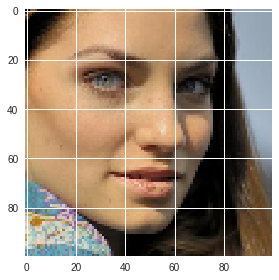

In [5]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

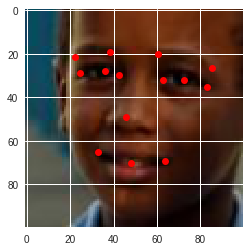

In [6]:
import matplotlib.pyplot as plt

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    fig, ax = plt.subplots()
    plt.imshow(img)
    for i in range(len(points) //2):
      plt.plot((points[i*2]+0.5)*100,(points[i*2+1]+0.5)*100, 'o',color = 'r' )
    
visualize_points(imgs[1], points[1])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [0]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

In [0]:
def flip_img(img, points):
    f_img = np.fliplr(img)
    f_points = np.copy(points)
    for i in range(14):
        f_points[2*i] = -points[2*i]
    
    return f_img,f_points

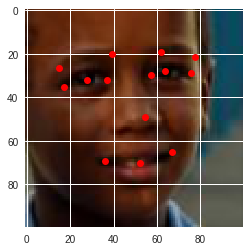

In [9]:
f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [0]:
def augmentSample(imgs_train, points_train):
  aug_imgs_train = []
  aug_points_train = []
  for img, imgPoints in zip(imgs_train,points_train):
    f_img, f_points = flip_img(img, imgPoints)
    aug_imgs_train.append(img)
    aug_points_train.append(imgPoints)
    aug_imgs_train.append(f_img)
    aug_points_train.append(f_points)
  return np.asarray(aug_imgs_train),np.asarray(aug_points_train)

In [0]:
aug_imgs_train, aug_points_train = augmentSample(imgs_train, points_train)

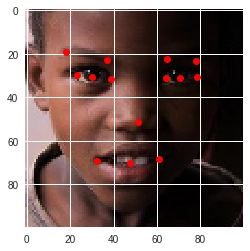

In [12]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

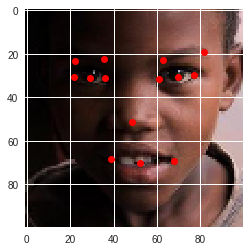

In [13]:
visualize_points(aug_imgs_train[3], aug_points_train[3])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [0]:
from keras.models import Sequential
from keras.layers import (
    InputLayer,Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout
)

model = Sequential()


model.add(InputLayer(aug_imgs_train[0].shape))
    
feat_filters = [32,64,128]
for filter in feat_filters:
  model.add(Conv2D(filter,(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten()) #flatten image to vector
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(aug_points_train.shape[1], activation='linear'))



In [41]:
# you can look at all layers and parameter count
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 12800)             0         
__________

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [42]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam

# Choose optimizer, compile model and run training
model.compile(loss='mse',
              optimizer=Adam(),
              metrics=['mse'])

model.fit(aug_imgs_train, aug_points_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(imgs_val, points_val))

Train on 10800 samples, validate on 600 samples
Epoch 1/10
10800/10800 [==============================] - 10s 915us/step - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0181 - val_mean_squared_error: 0.0181
Epoch 2/10
10800/10800 [==============================] - 9s 816us/step - loss: 0.0185 - mean_squared_error: 0.0185 - val_loss: 0.0162 - val_mean_squared_error: 0.0162
Epoch 3/10
10800/10800 [==============================] - 9s 817us/step - loss: 0.0177 - mean_squared_error: 0.0177 - val_loss: 0.0149 - val_mean_squared_error: 0.0149
Epoch 4/10
10800/10800 [==============================] - 9s 816us/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0171 - val_mean_squared_error: 0.0171
Epoch 5/10
10800/10800 [==============================] - 9s 817us/step - loss: 0.0163 - mean_squared_error: 0.0163 - val_loss: 0.0171 - val_mean_squared_error: 0.0171
Epoch 6/10
10800/10800 [==============================] - 9s 818us/step - loss: 0.0156 - mean_squared_error: 0.

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

In [43]:
# Example of output
predicted_keypoints=model.predict(imgs_val)
print(predicted_keypoints[0:5,:]) #check that outputs are different

[[-0.21516635 -0.2705769  -0.04526754 -0.2790588   0.13195036 -0.26333243
   0.2750933  -0.24555603 -0.18258034 -0.18607166 -0.11966038 -0.18833013
  -0.05869697 -0.17791149  0.12926579 -0.174591    0.18633631 -0.17022347
   0.22712539 -0.16385277  0.04071422  0.01769075 -0.11498132  0.17573145
   0.00660302  0.17914748  0.11228867  0.18166214]
 [-0.16725767 -0.28406185 -0.093149   -0.2904609   0.02952581 -0.29373047
   0.15348959 -0.30787215 -0.15794675 -0.18992087 -0.11876336 -0.19811173
  -0.07677907 -0.20021592  0.04671601 -0.20584866  0.09549564 -0.22036235
   0.13481168 -0.2211075  -0.02399737  0.02699293 -0.05820775  0.19911008
   0.01060707  0.20721965  0.09729163  0.18910743]
 [ 0.06005481 -0.24502903  0.10843182 -0.23293641  0.15224417 -0.22792783
   0.18176119 -0.21913746  0.03045156 -0.17051008  0.05350694 -0.1672048
   0.05822804 -0.16710366  0.10037705 -0.14648676  0.12093573 -0.15470973
   0.1316342  -0.15021399  0.00293296  0.04095859 -0.10666042  0.1319726
  -0.0636174

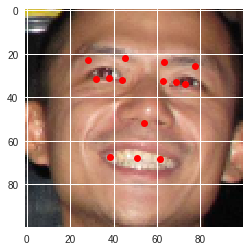

In [44]:
visualize_points(imgs_val[0],predicted_keypoints[0]) #visualize one image

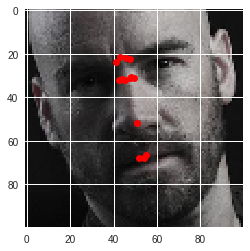

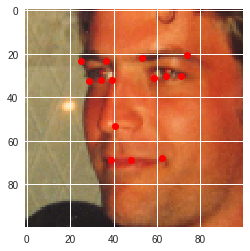

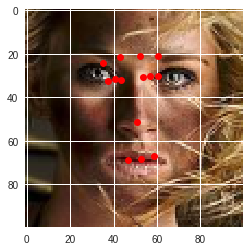

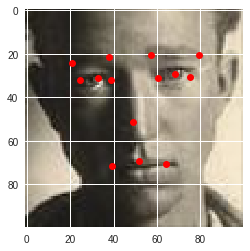

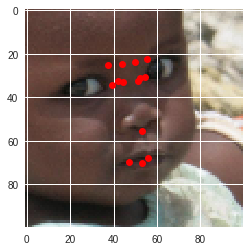

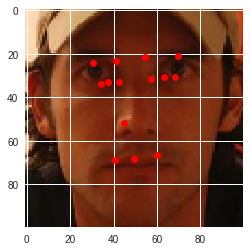

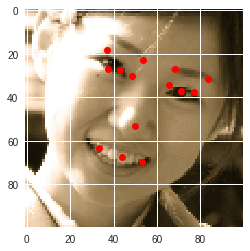

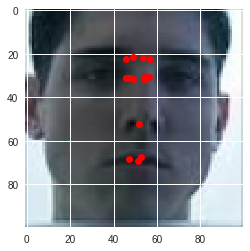

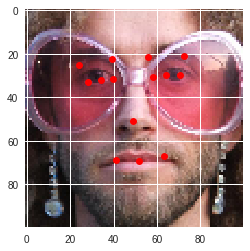

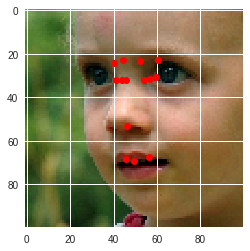

In [47]:
#visualize several others from validaation set
for i in range(10):
    ix=np.random.choice(range(imgs_val.shape[0]))
    visualize_points(imgs_val[ix],predicted_keypoints[ix])